In [1]:
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

base_dir = "Splitted_70-30"
test_dir = "test_img"
BATCH_SIZE = 32
IMAGE_SIZE = 224

datagen = ImageDataGenerator(
     rotation_range=30,
     width_shift_range=0.2,
     height_shift_range=0.2,
     zoom_range = 0.2,
     horizontal_flip=True,
     shear_range=0.2
    )

traingen = datagen.flow_from_directory(base_dir + "/train", 
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode="categorical")

valgen = datagen.flow_from_directory(base_dir + "/val", 
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode="categorical")

testgen = datagen.flow_from_directory(test_dir + "/test", 
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=1,
class_mode="categorical")

Found 1050 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [2]:
print(traingen.class_indices)
print(valgen.class_indices)
print(testgen.class_indices)

{'debrisflow': 0, 'earthflow': 1, 'rockfall': 2}
{'debrisflow': 0, 'earthflow': 1, 'rockfall': 2}
{'debrisflow': 0, 'earthflow': 1, 'rockfall': 2}


In [3]:
with tf.device('/device:GPU:0'):
  model = Sequential()

  model.add(VGG16(include_top=False, weights='imagenet',input_tensor=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))))
  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(3))
  model.add(Activation('softmax'))

  model.layers[0].trainable = False

  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(traingen, validation_data=valgen, epochs=100)

  model.save('Saved_Model/VGG70-30_100epochs.h5')

Epoch 1/100
33/33 [==============================] - 102s 3s/step - loss: 18.5983 - accuracy: 0.5200 - val_loss: 1.5920 - val_accuracy: 0.6600
Epoch 2/100
33/33 [==============================] - 101s 3s/step - loss: 1.1149 - accuracy: 0.6867 - val_loss: 0.7906 - val_accuracy: 0.7222
Epoch 3/100
33/33 [==============================] - 101s 3s/step - loss: 0.6706 - accuracy: 0.7495 - val_loss: 0.6265 - val_accuracy: 0.7622
Epoch 4/100
33/33 [==============================] - 101s 3s/step - loss: 0.5184 - accuracy: 0.7876 - val_loss: 0.5616 - val_accuracy: 0.7622
Epoch 5/100
33/33 [==============================] - 104s 3s/step - loss: 0.4943 - accuracy: 0.8076 - val_loss: 0.5429 - val_accuracy: 0.7956
Epoch 6/100
33/33 [==============================] - 104s 3s/step - loss: 0.4331 - accuracy: 0.8352 - val_loss: 0.5528 - val_accuracy: 0.7889
Epoch 7/100
33/33 [==============================] - 104s 3s/step - loss: 0.3572 - accuracy: 0.8648 - val_loss: 0.5450 - val_accuracy: 0.7978
Epoch

In [4]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                        

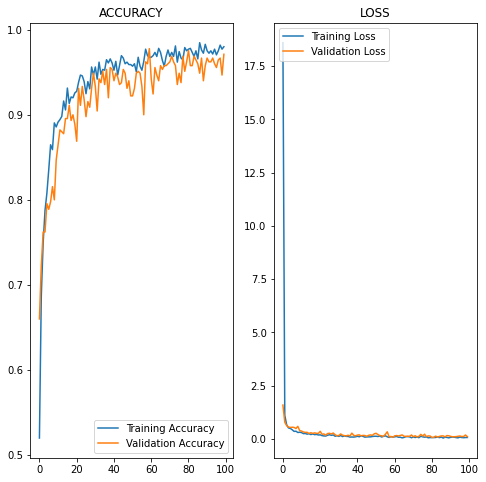

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.savefig('Splitted')

In [6]:
train_predictions = np.argmax(model.predict(traingen), axis=1)
class_predictions = np.argmax(model.predict(testgen), axis=1)

In [7]:
print("Loss of the model is - " , model.evaluate(testgen)[0])
print("Accuracy of the model is - " , model.evaluate(testgen)[1]*100 , "%")

9/9 [==============================] - 1s 93ms/step - loss: 3.7882 - accuracy: 0.4444
Loss of the model is -  3.7881948947906494
9/9 [==============================] - 1s 93ms/step - loss: 2.7637 - accuracy: 0.5556
Accuracy of the model is -  55.55555820465088 %


              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.33      0.50         3
           2       0.50      1.00      0.67         3

    accuracy                           0.67         9
   macro avg       0.83      0.67      0.66         9
weighted avg       0.83      0.67      0.66         9



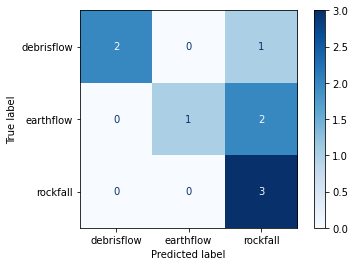

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["debrisflow", "earthflow", "rockfall"]

print(classification_report(testgen.labels,class_predictions))

cm = confusion_matrix(testgen.labels,class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()